# Quora Questions

The goal of this project is to identify insincere questions in a dataset of around 1 300 000 questions from Quora. The questions are about various topics and vary in length.


In [20]:
## Imports
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import pickle
import string
import random

from keras.preprocessing.text import Tokenizer
import keras.preprocessing.sequence as sq

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sn

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 20, 10
plt.rcParams.update({'font.size': 25})

from IPython.display import clear_output

## 1. Data exploration

There are over 1 300 000 sentences in the dataset.

We are going to use the GloVe 300 embedding from Common Crawl [1].

In [3]:
# Load data and embedding
path_in = './data/'

train = pd.read_csv(path_in + 'train.csv')

train = train[0:10000]
#test = pd.read_csv(path_in + 'test.csv')

### 1.1 Example sentences

The sentences are in `question_text` and the label is in `target`, where `1` is a positive (insincere) and `0`a negative. Here is an example sentence along with the label:

In [4]:
print("Example sentence: \"{}\"\nLabel: {}".format(train['question_text'][8], train['target'][8]))

Example sentence: "Is there such a thing as dressing moderately, and if so, how is that different than dressing modestly?"
Label: 0


Let's see how many positives and negatives we have in the data:

In [5]:
print("Ratio of positives to total: {:.2f}%".format(len(train.loc[train['target'] == 1])*100 / len(train)))

Ratio of positives to total: 6.37%


That means our model can achieve an accuracy of around 95% purley by guessing. This shows that the accuracy score is not a good metric to quanitify a model when having strongly unbalanced data and is known as the *class imbalance problem* [2]. 

### 1.2 Sentence structures and ratio

To get an idea about the data we are dealing with, we see how many characters are in sentence. Characters include both words and punctuation.

In [ ]:
def getNumberofWordsFound():
    ## Generate random
    population = list(np.arange(0, len(train)))
    population = random.sample(population, 100)
    
    number_of_words = []
    
    for sample in population:
        sentence = train['question_text'].iloc[int(sample)]

        ## Convert to lowercase and split sentence
        sentence = sentence.lower()

        ## Sepearate punctuation
        chs = string.punctuation
        for ch in chs:
            idx = sentence.find(ch)

            if idx != -1:
                sentence = sentence.replace(ch, " " + ch)

        sentence = sentence.split(' ') 
        number_of_words.append(len(sentence))
        
    return number_of_words


num_of_words = getNumberofWordsFound()

In [ ]:
plt.hist(num_of_words, range=(0, 30), color="green")
plt.title("Number of characters per sentence")
plt.xlabel("# characters")
plt.ylabel("# sentences")
plt.show()
plt.show()

**Question:**

According to the Central Limit Theorem, samples from a population of any distribution are normally distributed, given that the samples are independent. Since the distribution above isn't normal, it follows that the length of sentences is not independent. What is the explanation?

## 2. Data Preparation
We cannot just feed sentences to our network. Instead, we perform the following steps:

* Generate a vocabulary with all words/characters in the data

* Tokenize this vocabulary

* Get union of vocabulary and embedding

* Use tokens to express individual sentences as vectors

* Pad/truncate the vectors so that all have the same length

This steps can be done with libraries like in *Keras*. For illustrative purposes we first implement the steps fom scratch. Afterwards we use the *Keras* library to achieve the goal more efficiently.

### 2.1 The hard way

The words are converted to lowercase and punctuation is isolated.

In [ ]:
def make_vocabulary(data):
    '''
    Input:
    data: series of sentences for which to build the vocabulary
    
    Output:
    Dictionary of words and their frequency
    '''
    vocab = {}
    for sentence_number in range(len(data)):
        clear_output(wait=True)
        print("Processing sentence {} / {}".format(sentence_number+1 ,len(data)))
        sentence = data[sentence_number]
                
        ## Sepearate punctuation
        chs = string.punctuation
        
        for ch in chs:
            idx = sentence.find(ch)

            if idx != -1:
                sentence = sentence.replace(ch, " " + ch)
        
        ## Split into words
        sentence = sentence.split(' ')   
        
        for word in sentence:
            word = word.lower()
            try:
                vocab[word] += 1
            except KeyError:
                    vocab[word] = 1
        
    print("Done")
        
    return vocab

vocab = make_vocabulary(train['question_text'][0:5000])

# Save the vocabulary
with open('./data/Vocabulary.p', 'wb') as handle:
    pickle.dump(vocab, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
vocab = pickle.load(open("./data/Vocabulary.p", "rb") )

### Union of vocabulary and embedding

Check which words from the vocabulary can be found in the embedding. We also provide statistics.

In [ ]:
def getUnion(vocab, embedding):
    '''
    Input: vocab and embedding as dictionary
    Output: union as list with words
    '''
    vocab = list(vocab.keys())
    embedding = list(embedding.keys())
    
    union = []
    i = 0
    for word in embedding:
        clear_output(wait=True)
        print("Processing word {} / {}".format(i ,len(embedding)))
        
        if word in embedding:
            union.append(word)
        i += 1
    
    return union

union = getUnion(vocab, embedding)

# Save the union
with open('./data/Union.p', 'wb') as handle:
    pickle.dump(union, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
union = pickle.load(open("Union.p", "rb") )

print("Percent of words from vocabulary in embedding: {:.2f} ".format(len(union) / len(list(embedding.keys()))))

### Tokenization

For the net to process the input sentences the sentences have to be tokenized. That's why we create a weight matrix now. It has the dimension `[sequence len, sample, dimension]`, where the sequence length is 45 and the dimension is 300 (given from the embedding).

Consequently, a sentence from the dataset is represented as a tuple of 45 vectors with dimension 300.

In [4]:
seq_len = 45
dimension = 50
number_samples = 1000


## Initialize matrix
weights = np.zeros((number_samples, seq_len, dimension))
labels = []

## Extract weight matrix for each sample
for sample in range(number_samples):
    sentence = train['question_text'].iloc[sample]
    label = train['target'].iloc[sample]
    labels.append(label)
    
    
    ## Convert to lowercase and split sentence
    sentence = sentence.lower()

    ## Sepearate punctuation
    chs = string.punctuation
    for ch in chs:
        idx = sentence.find(ch)
        
        if idx != -1:
            sentence = sentence.replace(ch, " " + ch)
            
    sentence = sentence.split(' ')   
    
     ## Truncate
    sentence = sentence[0:seq_len]

    ## Find weights
    matrix_len = len(sentence)
    weights_matrix = np.zeros((matrix_len, dimension))
    words_found = 0

    for i, word in enumerate(sentence):
        try: 
            weights_matrix[i] = embedding[word]
            words_found += 1
        except KeyError:
            weights_matrix[i] = np.random.normal(scale=0.6, size=(dimension, ))    
    
    
    ## Pad with zeros to 45
    z = np.zeros((1, dimension))
    
    for i in range(seq_len-matrix_len):      
        weights_matrix = np.concatenate((weights_matrix, z), axis=0)
     
    weights[sample, :, :] = weights_matrix


print("Dimension of weight matrix: {}".format(weights.shape))    
print("Ratio positives/total: {}".format(labels.count(1)/number_samples))


## Convert to torch tensors
weights = torch.tensor(weights)
weights = weights.float()  

labels = torch.tensor(labels).float()

NameError: name 'embedding' is not defined

### 2.2 The easy way - Keras tokenizer

We now split the dataset into train, validation and testing. We also utilize the PyTorch Datalaoder functions to simplify batching.

In [6]:
# Build the tokenizer dictionary in the tokenizer class
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(train['question_text'])

# Split train set into train and validation sets
train, validation = train_test_split(train, test_size=0.1, shuffle = True)
train.reset_index(inplace=True)
validation.reset_index(inplace=True)

# Tokenize the questions
train_sequences = tokenizer.texts_to_sequences(train['question_text'])
validation_sequences = tokenizer.texts_to_sequences(validation['question_text'])

# Save the tokenizer dictionary and the number of words in it
word_index = tokenizer.word_index
vocab_size = len(word_index)

First we tokenize all words in the data using the `Tokenizer` from the Keras library. Note that we filter out the characters given to the `filters` attribute.

Next, we split the data into training and validation data.

Finally, using the tokens defined in the first step, we can tokenize the indivdual sentences from the questions. That way, we get a vector for each sentence. Here, the length is the number of words, exlcuding the characters in the filter.

**Output:**

`word_index`Dictionary of word and assigned number (token)

`vocab_size` Int number of words in vocabulary

TODO:
* Merge similar words together
* Include punctuation

In [7]:
## Pad sequences with 0s so that each sequence is of the same length respresented by the max_length
max_length = 50
padding_type = 'pre'
trunc_type = 'pre'

train_sequences_padded = sq.pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
validation_sequences_padded = sq.pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [8]:
## Convert data to tensors
training_dataset = torch.utils.data.TensorDataset(torch.LongTensor(np.array(train_sequences_padded)), torch.FloatTensor(np.array(train['target'])))
validation_dataset = torch.utils.data.TensorDataset(torch.LongTensor(np.array(validation_sequences_padded)), torch.FloatTensor(np.array(validation['target'])))

In the dataset for training, we now have an array of length 50 with tokens for each sentence.

### 2.3 Embedding
We use the GloVe 300 ... embedding. It was trained on ??. We want to get a tensor which includes the 300 dimensional weights for all words in our vocabulary. This `embedding_matrix` is used later by the embedding layer.

In [9]:
def load_embedding(embedding_File, embedding_dim, vocab_size, word_index):
    print('Loading word embeddings...')
    embedding_index = {}
    with open(embedding_File,'r', encoding = 'utf8') as f:
        for line in f:
            values = line.split();
            word = ''.join(values[:-1*embedding_dim]);
            coefs = np.asarray(values[-1*embedding_dim:], dtype='float32');
            embedding_index[word] = coefs;

    embedding_matrix = np.zeros((vocab_size+1, embedding_dim));
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word);
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector;  
            
    print('Finished loading word embeddings. {:.0f} words loaded.'.format(len(embedding_matrix)))
    return embedding_matrix

## Load embedding
embedding_dim = 50
embedding_File = './data/embeddings/glove.6B.50d.txt'

embedding_matrix = load_embedding(embedding_File, embedding_dim, vocab_size, word_index)
weights = torch.FloatTensor(embedding_matrix)

Loading word embeddings...
Finished loading word embeddings. 15809 words loaded.


## 3. Prediction

### 3.1 Net
The net has an embedding layer which feeds into the LSTM layer. The LSTM is connected to a linear layer.

For the LSTM layer we want a many-to-one architecture. That means we want to feed in the sequence (whole sentence) and get one output.

The LSTM layer has the outputs `lstm_out, (h_n, c_n)`. To get the many-to-one output, you can either take the last element of the sequence `lstm_out`, or `h_n` which is the same. For more info see the documentation [https://pytorch.org/docs/stable/nn.html#lstm].

In [66]:
class Net(nn.Module):
    def __init__(self, seq_length, hidden_layer_1):
        super(Net, self).__init__()
        
        ## Embedding layer
        self.embd = nn.Embedding.from_pretrained(weights)
        
        ## LSTM
        self.lstm = nn.LSTM(input_size=len(weights[0,:]), hidden_size=hidden_layer_1, batch_first=True)
        
        ## Linear layers
        self.fc1 = nn.Linear(hidden_layer_1, 1)
        self.tanh = nn.Tanh()
        self.out = nn.Sigmoid()
        
        self.initialize()
        
    def initialize(self):
        nn.init.xavier_uniform_(self.fc1.weight.data)
        self.fc1.bias.data.zero_()
      

    def forward(self, x):
        embd_out = self.embd(x)       
        lstm_out, (h_out, _) = self.lstm(embd_out)
        x = self.tanh(self.fc1(h_out))       
        x = self.out(x)      
        return x

### 3.2 Train the net

In [71]:
### Function for training
epochs = 30
learning_rate = 0.0001
momentum = 0.9

seq_length = 50
hidden_layer_1 = 50

batch_size = 100


## Define dataloader
train_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=len(validation_dataset), shuffle=False)

## Initialize net and define loss function and optimizer
model = Net(seq_length, hidden_layer_1)
criterion = nn.BCELoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)


##### Iterate through the data
loss_acc = {'Loss': [], 'Train accuracy': [], 'Validation accuracy':[]}

for epoch in range(epochs):
    print("Epoch {} / {}".format(epoch+1, epochs))

    train_correct = 0    
    model.train()
    
    for x, y in train_loader:
        # Set gradients to zero
        optimizer.zero_grad()
        
        # Forward pass
        y_hat = model(x)
        
        # Evaluate output / compute loss
        y_hat = y_hat.view(-1)        
        loss = criterion(y_hat, y)       
        
        # Backward pass / optimize
        loss.backward()
        
        # Update weights
        optimizer.step()
                
        ## Evaluate train result
        y_hat = np.where(y_hat.detach().numpy() > 0.5, 1, 0)
        train_correct += (y_hat == y.numpy()).sum()
    
    train_acc = train_correct / len(train_loader.dataset)
    loss_acc['Loss'].append(loss.item())
      
        
    # Get validation accuracy
    val_correct = 0
    with torch.no_grad():
        for x, y in validation_loader:
            y_hat = model(x)
            y_hat = y_hat.view(-1)

            ## Evaluate validation result
            y_hat = np.where(y_hat.numpy() > 0.5, 1, 0)
            val_correct += (y_hat == y.numpy()).sum()
    
    val_acc = val_correct / len(validation_loader.dataset)
    
    
    # Append scores to dictionary
    loss_acc['Train accuracy'].append(train_acc)
    loss_acc['Validation accuracy'].append(val_acc)
    
    print("Loss: {:.4f}".format(loss_acc['Loss'][-1]))
    print("Training accuracy: {:.4f} | Validation accuracy: {:.4f}".format(loss_acc['Train accuracy'][-1], loss_acc['Validation accuracy'][-1]))

## Save the model
#torch.save(model.state_dict(), './quora_questions_classifier.pt')
    
print("\nTraining completed!")

Epoch 1 / 20
Loss: 0.6977
Training accuracy: 0.4419 | Validation accuracy: 0.4820
Epoch 2 / 20
Loss: 0.6807
Training accuracy: 0.5351 | Validation accuracy: 0.5830
Epoch 3 / 20
Loss: 0.6633
Training accuracy: 0.6356 | Validation accuracy: 0.6690
Epoch 4 / 20
Loss: 0.6409
Training accuracy: 0.7184 | Validation accuracy: 0.7320
Epoch 5 / 20
Loss: 0.6334
Training accuracy: 0.7874 | Validation accuracy: 0.7910
Epoch 6 / 20
Loss: 0.6094
Training accuracy: 0.8368 | Validation accuracy: 0.8320
Epoch 7 / 20
Loss: 0.5911
Training accuracy: 0.8658 | Validation accuracy: 0.8620
Epoch 8 / 20
Loss: 0.5847
Training accuracy: 0.8852 | Validation accuracy: 0.8860
Epoch 9 / 20
Loss: 0.5806
Training accuracy: 0.8984 | Validation accuracy: 0.9050
Epoch 10 / 20
Loss: 0.5772
Training accuracy: 0.9076 | Validation accuracy: 0.9150
Epoch 11 / 20
Loss: 0.5405
Training accuracy: 0.9154 | Validation accuracy: 0.9200
Epoch 12 / 20
Loss: 0.5382
Training accuracy: 0.9198 | Validation accuracy: 0.9200
Epoch 13 / 20

Text(0,0.5,'Accuracy [%]')

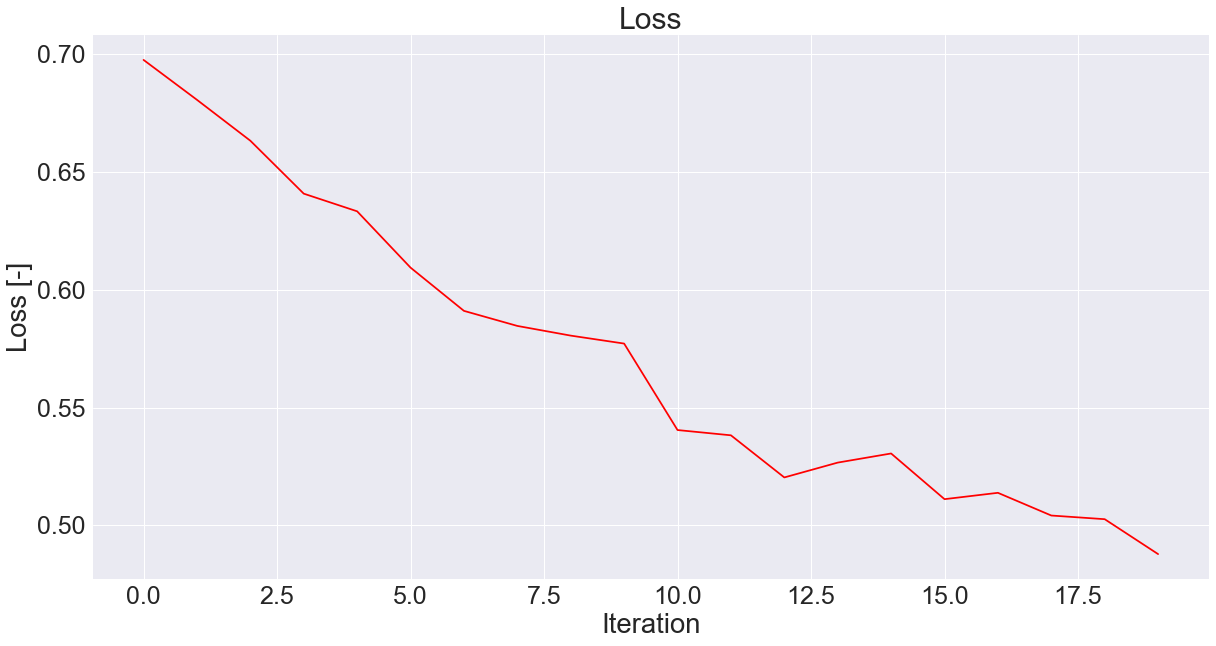

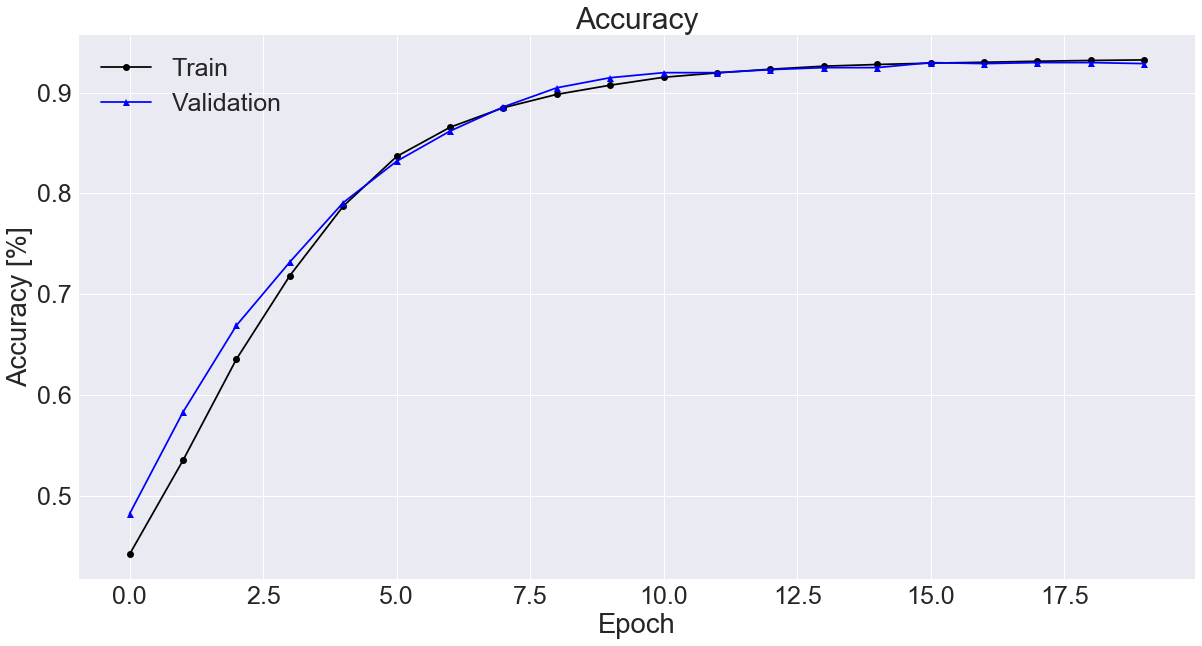

In [72]:
## Plots
fig = plt.figure(1)
plt.plot(loss_acc['Loss'], color="red")
plt.title("Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss [-]")

fig = plt.figure(2)
plt.plot(loss_acc['Train accuracy'], "o-", color="black", label="Train")
plt.plot(loss_acc['Validation accuracy'], "^-",color="blue", label="Validation")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.ylabel("Accuracy [%]")

## 4. Evaluation

Finally we evaluate the performance of our model in more detail. Note that we use the validation data again for this. This is okay in this case since the model has not been tuned based on this data, even though it has been used during the training. However, a cleaner approach would be to have training, validation and testing data.

Let's compute a few metrics. We begin with the accuracy:

In [73]:
## Use trained model for validation
model.eval()

for x, y in validation_loader:
    validation_data = x
    validation_labels = y

pred = model(validation_data)
pred = pred.squeeze()
predicted_labels = np.where(pred > 0.5, 1, 0)

accuracy_score(np.array(validation_labels), predicted_labels)

0.929

In [74]:
predicted_labels.sum()

6

As mentioned earlier, in unbalanced data other metrics can be more useful to assess the model's performance. Let's look at:

*precision* $= \frac{t_{p}}{t_{p} + f_{p}}$


*recall* $= \frac{t_{p}}{t_{p} + f_{n}}$


*F1-Score* $= 2\cdot \frac{precision \cdot recall}{precision + recall}$

In [75]:
def Compute_Metrics():
    precision = precision_score(validation_labels, predicted_labels)
    print("Precision: {:.4f}".format(precision))
    
    recall = recall_score(validation_labels, predicted_labels)
    print("Recall: {:.4f}".format(recall))
    
    f1 = f1_score(validation_labels, predicted_labels)
    print("F1 Score: {:.4f}".format(f1))
    
    return precision, recall, f1

precision, recall, f1 = Compute_Metrics()

Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


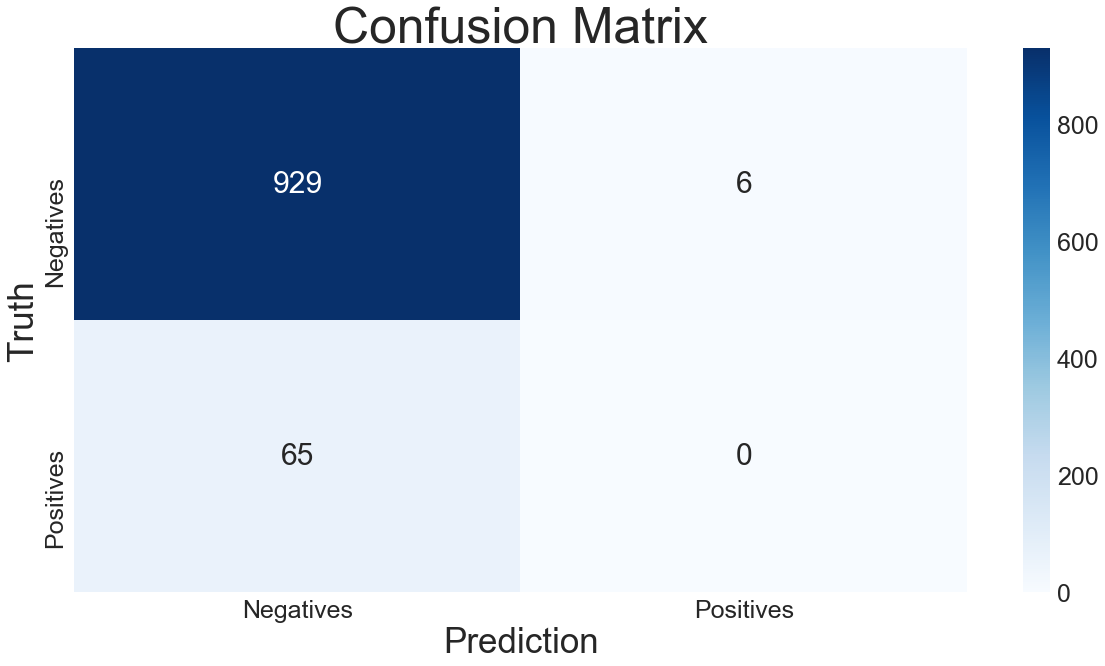

In [76]:
## Confusion matrix
def Confusion_Matrix(con_mat):
    
    plt.title("Confusion Matrix", fontsize=50)
    sn.set(font_scale=2.5)
    sn.heatmap(con_mat, annot=True, fmt='g', annot_kws={"size":30}, xticklabels=["Negatives", "Positives"], yticklabels=["Negatives", "Positives"], 
               cmap="Blues")
    plt.xlabel("Prediction", fontsize=35)
    plt.ylabel("Truth", fontsize=35)

    
con_mat = confusion_matrix(validation_labels, predicted_labels)
Confusion_Matrix(con_mat)

### Conclusion

## References
[1] Jeffrey Pennington, Richard Socher, and Christopher D. Manning. *GloVe: Global Vectors for Word Representation*. 2014.

[2] Han, Kamber, Pei. *Data Mining: Concepts and Techniques*. 2011